In [1]:
""" 
通过1个epoch 完成在cpu下执行 并且要连上实验记录的工具 再然后进行实验
快速跑通代码的过程是 epoch 要少，数据量要少，数据的长度要少；
"""
# # Exp()._acquire_device(args)
# from torch.utils.tensorboard import SummaryWriter
# import swanlab
# import os
# os.environ["Swanlab_API_KEY"] = "jkQi1t18b9GM328ZVkiOb"
# swanlab.login()

' \n通过1个epoch 完成在cpu下执行 并且要连上实验记录的工具 再然后进行实验\n快速跑通代码的过程是 epoch 要少，数据量要少，数据的长度要少；\n'

In [2]:
# swanlab.init(
#   # 设置将记录此次运行的项目信息
#   project="autoformer",
#   logdir='./logs',
#   mode='local'
# )

In [3]:
# """  
# 数据缩量
# """
# import pandas as pd 
# df_old1 = pd.read_csv('./dataset/ETT-small/ss_test.csv')
# df_old1 = df_old1.sort_values('date')
# df_old=pd.DataFrame()
# df_old['OT']=list(range(100))
# df_old['date']=df_old1['date'][:300]
# df_old1.head()
# df_old.to_csv('num.csv',index=False)

# print(df_old.shape)
# df_old1[500:600].to_csv('./dataset/ETT-small/ss_test_1000.csv',index=False)
# df_old = pd.read_csv('./dataset/ETT-small/ETTh1_1000.csv')
# df_old.head()
# df_old.shape

In [4]:
# sorted(df_old1.date.tolist())[500:800]
# df_old1[500:800]

In [5]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main#exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 42 
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')#模型id
parser.add_argument('--model', type=str, required=True, default='Autoformer',#选择模型
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')#数据类型
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')#数据文件夹路径
parser.add_argument('--data_path', type=str, default='ETTh1_1000.csv', help='data file')#具体文件
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')#不太懂 OT好像代表Output Target,要预测的单变量
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')#保存模型

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')#输入序列长度
parser.add_argument('--label_len', type=int, default=48, help='start token length')#这个label_len未完全搞懂
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')#输出序列长度

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#输出长度
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads 
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#窗口滑动平均数
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor不太理解
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)#是否在encoder里面使用知识蒸馏
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding不太能get到
parser.add_argument('--activation', type=str, default='gelu', help='activation')#激活函数default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoder的output_attention是否输出
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')#是否预测未见的未来数据,也就是是否进行推理的意思

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers是加载数据(batch)的线程数目
parser.add_argument('--itr', type=int, default=2, help='experiments times')#实验次数
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: 当early stop被激活(如发现loss相比上一个epoch训练没有下降)，则经过patience个epoch后停止训练
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#使用自动混合精度训练

# GPU
parser.add_argument('--use_gpu', type=bool, default=False, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'OT'
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
# args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = False
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #是否使用多卡的判断
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './dataset/ETT-small/'
args.data_path ='ss_test_1000.csv' 
args.model_id='ss_test'
args.model = 'Autoformer'
args.data = 'custom'
args.features = 'S'
args.seq_len = 56
args.label_len = 14
args.pred_len = 7
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 1
args.enc_in = 1
args.dec_in =1
args.c_out = 1
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 7
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 7
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10
args.use_gpu=False
print('Args in experiment:')
print(args)

Exp = Exp_Main




Args in experiment:
{'target': 'OT', 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'lradj': 'type1', 'devices': '0', 'use_gpu': False, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': './dataset/ETT-small/', 'data_path': 'ss_test_1000.csv', 'model_id': 'ss_test', 'model': 'Autoformer', 'data': 'custom', 'features': 'S', 'seq_len': 28, 'label_len': 14, 'pred_len': 7, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 1, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 7, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


In [6]:
exp = Exp(args)  # set experiments

Use CPU


In [7]:
from data_provider.data_factory import data_provider
train_data_set, train_data_loader = data_provider(args,'train')
val_data_set, val_data_loader = data_provider(args,'val')
test_data_set, test_data_loader = data_provider(args,'test')

dataloader-> num_train: 210,num_test:30,num_vali: 60 
finsh build data_set:  train 176
dataloader-> num_train: 210,num_test:30,num_vali: 60 
finsh build data_set:  val 54
dataloader-> num_train: 210,num_test:30,num_vali: 60 
finsh build data_set:  test 24


In [8]:
len(test_data_set.time_index)

58

In [9]:
# num_train: 70,num_test:10,num_vali: 20 
# args.seq_len = 14  args.label_len = 4  args.pred_len = 2
# data_set: train= 55,val = 19, test 9
# seq_x = 14个，seq_y = 
# 训练集：x的序列就是：num_train-seq_len+1

# 验证集：num_val+seq_len = 20+14= 34 ，34-14= 20
# 测试集：num_test+seq_len = 10+14 = 24, 24-14 = 10
# 10 5 1~5,5~6

# train：序列是[0:num_train] = [0:70] 70个
# val：序列是[num_train - self.seq_len,num_train + num_vali]=[56:90] 长度是 34 = 20+14
# test：序列是[len(df_raw) - num_test - self.seq_len,len(df_raw)] = [76,100] 长度 24=10+14

# 任意数据集样本个数计算公式
# len(self.data_x) - self.seq_len - self.pred_len + 1
# 训练集 = 70 - 14 -2 +1 = 55
# 验证集 = 34 -14 -2 + 1 = 19
# 测试集 = 24 -14 -2 + 1 = 9
# x-14-2+1=1
# x=16
# pre_len=10
# seq_len = 4*pre_len
# 整体序列的长度 = 10*pre_len = 180条=2个月
# pre_len = 1*pre_len
# num_train = 7*pre_len
# 
# seq_len = 4*pre_len
# 7-4-1+1 = 3*pre_len样本
# label=2*pre_len


In [10]:
# for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
#     print(batch_x.shape)
#     print(batch_x.numpy()[-1,:,-1])
#     print(batch_y.shape)
#     print(batch_y.numpy()[-1,:,-1])
#     break

In [11]:
# for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_data_loader):
    # print(batch_x.shape)
    # print(batch_x.numpy()[-1,:,-1])
    # print(batch_y.shape)
    # print(batch_y.numpy()[-1,:,-1])
    # break

In [12]:
# args.lable_len

In [13]:
# test_data_set.time_index
# args.seq_len,args.label_len,args.pred_len,test_data_set.time_index.shape
# test_data_set.time_index[args.seq_len+i:args.seq_len+args.pred_len+i]['date'].tolist()

In [14]:
# for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
#     # print(batch_x.shape)
#     print(f"batch: {i} : ")
#     print('seq_x: ',batch_x.numpy()[-1,:,-1],'长度: ',batch_x.shape[1])
#     # print(batch_y.shape)
#     print('seq_y: ',batch_y.numpy()[-1,:,-1],'长度: ',batch_y.shape)
#     print('time_index: ',test_data_set.time_index[args.seq_len+i:args.seq_len+args.pred_len+i]['date'].tolist())
    
    # break

In [15]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):#itr就是实验次数可不是epoch，parser.add_argument('--itr', type=int, default=2, help='experiments times')
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)#setting是用来保存模型的名字用的，很细节
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    # 释放缓存的，cpu暂时不用
    # torch.cuda.empty_cache()
    print(3)


Use CPU
1
>>>>>>>start training : ss_test_Autoformer_custom_ftS_sl28_ll14_pl7_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
dataloader-> num_train: 210,num_test:30,num_vali: 60 
finsh build data_set:  train 176
dataloader-> num_train: 210,num_test:30,num_vali: 60 
finsh build data_set:  val 54
dataloader-> num_train: 210,num_test:30,num_vali: 60 
finsh build data_set:  test 24
Epoch: 1 cost time: 56.72993993759155
Epoch: 1, Steps: 25 | Train Loss: 1578.0409009 Vali Loss: 1826.3165283 Test Loss: 1715.6153564
Validation loss decreased (inf --> 1826.316528).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 57.18158984184265
Epoch: 2, Steps: 25 | Train Loss: 1514.6329321 Vali Loss: 1538.1855469 Test Loss: 1424.4897461
Validation loss decreased (1826.316528 --> 1538.185547).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 57.193974018096924
Epoch: 3, Steps: 25 | Train Loss: 1465.4823193 Vali Loss: 1337.9616699 Test Lo

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/ss_test_Autoformer_custom_ftS_sl28_ll14_pl7_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

%matplotlib inline
plt.show()

In [ ]:


df = pd.read_csv('./test_res_df.csv')
df['date'] = df['date'].astype(str)

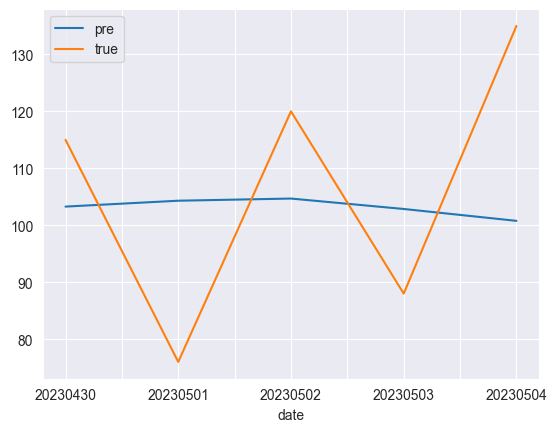

In [ ]:
df[:5].plot(x='date',y=['pre','true'])
plt.show()

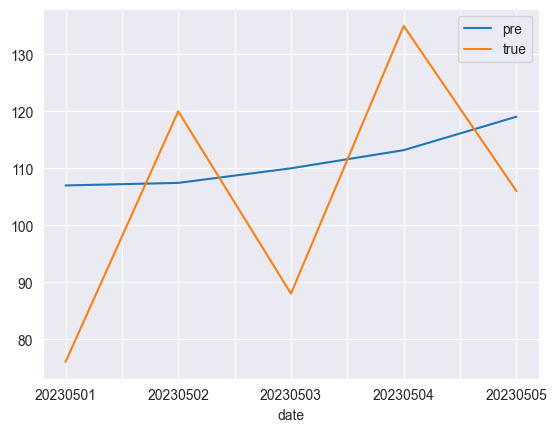

In [ ]:
df[5:10].plot(x='date',y=['pre','true'])
plt.show()

In [ ]:
df['diff_'] = df['pre']-df['true']
sum(abs(df['diff_']))/sum(df['true'])

0.27820250529328944

In [ ]:
# df['avg'] = df[]
org = pd.read_csv('./dataset/ETT-small/ss_test_1000.csv')
org['avg'] = org['OT'].rolling(7).mean().shift(1)
org.head(10)

,OT,date,avg
0,125.0,20220803,NaN
1,114.0,20220804,NaN
2,152.0,20220805,NaN
3,139.0,20220806,NaN
4,180.0,20220807,NaN
5,199.0,20220808,NaN
6,175.0,20220809,NaN
7,169.0,20220810,154.857143
8,148.0,20220811,161.142857
9,122.0,20220812,166.000000


In [ ]:
org['date'] = org['date'].astype(str)

In [ ]:
ddf = pd.merge(df,org[7:],on=('date'))

In [ ]:
ddf['diff_'] = ddf['avg']-ddf['true']
sum(abs(ddf['diff_']))/sum(ddf['true'])

0.26762448682736273

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
# 07_paper/Autoformer-main/results/ETTh1_96_24_Autoformer_custom_ftM_sl28_ll14_pl7_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0
data_pred = np.load('./results/sim_df_Autoformer_custom_ftS_sl20_ll10_pl5_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
# data_pred = np.load('./results/ETTh1_96_24_Autoformer_custom_ftM_sl28_ll14_pl7_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0')
data_pred = torch.from_numpy(data_pred)
# .permute(0,2,1)
data_gt = np.load('./results/sim_df_Autoformer_custom_ftS_sl20_ll10_pl5_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
data_gt = torch.from_numpy(data_gt)
data_pred.shape,data_gt.shape

(torch.Size([6, 5, 1]), torch.Size([6, 5, 1]))

In [19]:
data_pred.detach().numpy()

array([[[89.819725],
        [91.30624 ],
        [91.17568 ],
        [92.68755 ],
        [94.267494]],

       [[90.85327 ],
        [92.3727  ],
        [92.25139 ],
        [93.76555 ],
        [95.358376]],

       [[91.765816],
        [93.34248 ],
        [93.19358 ],
        [94.7492  ],
        [96.12475 ]],

       [[92.78558 ],
        [94.35481 ],
        [94.260765],
        [95.581024],
        [97.13902 ]],

       [[93.80398 ],
        [95.430855],
        [95.09874 ],
        [96.61501 ],
        [98.14933 ]],

       [[      nan],
        [      nan],
        [      nan],
        [      nan],
        [      nan]]], dtype=float32)

In [22]:
data_pred[0,:,-1],data_pred[1,:,-1],data_pred[2,:,-1]

(tensor([89.8197, 91.3062, 91.1757, 92.6876, 94.2675]),
 tensor([90.8533, 92.3727, 92.2514, 93.7655, 95.3584]),
 tensor([91.7658, 93.3425, 93.1936, 94.7492, 96.1247]))

In [23]:
data_gt[0,:,-1],data_gt[1,:,-1],data_gt[2,:,-1]

(tensor([90., 91., 92., 93., 94.]),
 tensor([91., 92., 93., 94., 95.]),
 tensor([92., 93., 94., 95., 96.]))

torch.Size([6, 5, 1])


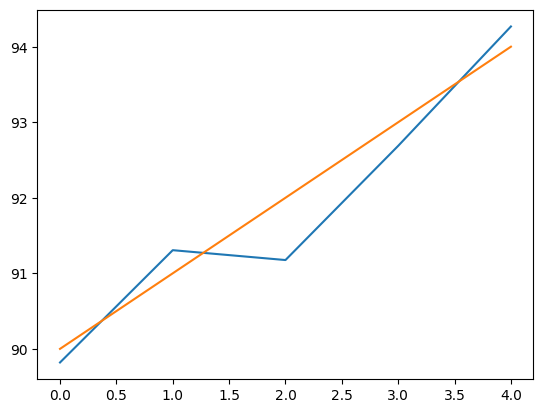

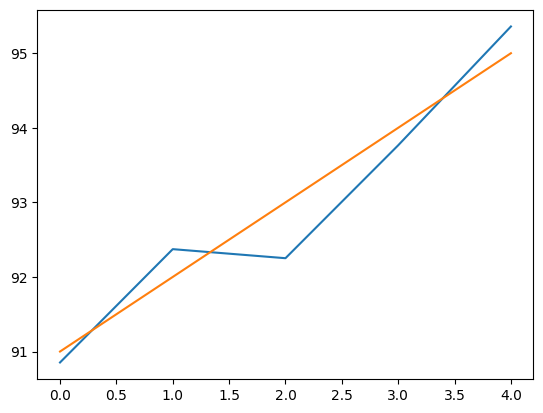

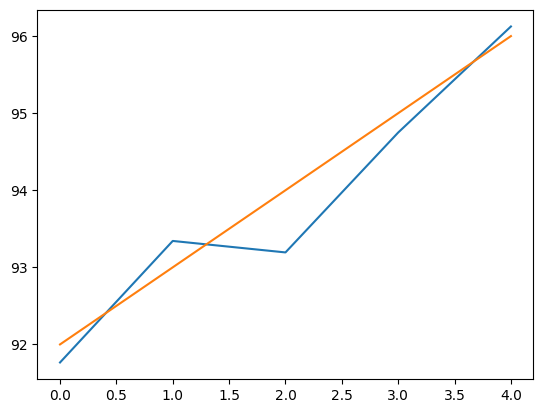

In [24]:

plt.figure()
print(data_pred.shape)
#预测OT
plt.plot(data_pred[0,:,-1])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
# print(data_pred[-1,-1,:].shape)
#预测OT
plt.plot(data_gt[0,:,-1])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
plt.show()

plt.plot(data_pred[1,:,-1])#没问题
plt.plot(data_gt[1,:,-1])#没问题
plt.show()
plt.plot(data_pred[2,:,-1])#没问题
plt.plot(data_gt[2,:,-1])#没问题
plt.show()


In [17]:
data_pred.shape

torch.Size([6, 1, 5])

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example #模仿informer 的 colab example的custom_dataset与predict部分
import pandas as pd
exp.args.root_path = './dataset/ETT-small/'
exp.args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [ ]:

args.do_predict = True
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)#data_factory做好了pred里面的batch_size=1的情况，是autoformer在informer基础之上做的
    torch.cuda.empty_cache()
    # print(prediction.shape)

>>>>>>>predicting : ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


torch.Size([1, 7, 24])
torch.Size([24])


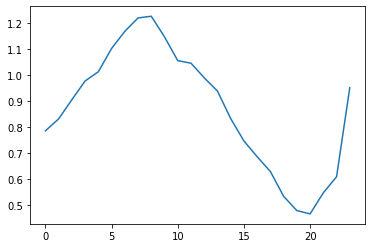

torch.Size([24])


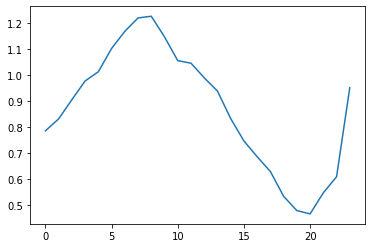

torch.Size([24])


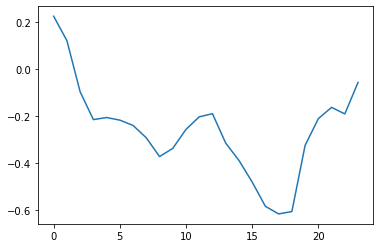

torch.Size([24])


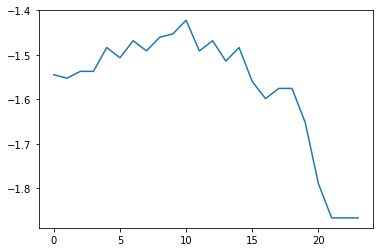

torch.Size([24])


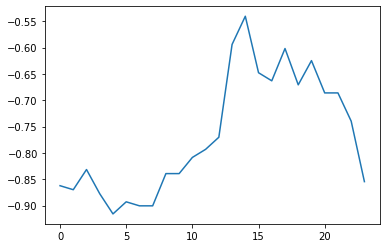

torch.Size([24])


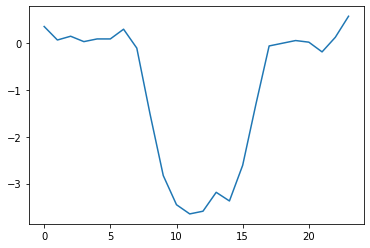

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
# data_pred = np.load('./results/ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
data_pred = np.load('./results/ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/real_prediction.npy')
data_pred = torch.from_numpy(data_pred).permute(0,2,1)

plt.figure()
print(data_pred.shape)
#预测OT
plt.plot(data_pred[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_pred[-1,-1,:].shape)
plt.show()
plt.plot(data_pred[0,-1,:])#没问题
print(data_pred[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_pred[0,0,:])#没问题
print(data_pred[-1,-1,:].shape)
plt.show()
'''
Ground Truth
'''
data_gt = np.load('./results/ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
data_gt = torch.from_numpy(data_gt).permute(0,2,1)

#预测OT
plt.plot(data_gt[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_gt[-1,-1,:].shape)
plt.show()
plt.plot(data_gt[0,-1,:])#没问题
print(data_gt[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_gt[0,0,:])#没问题
print(data_gt[-1,-1,:].shape)
plt.show()

